In [1]:
## fewer exclusions.  Don't throw out good data. 

In [382]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [383]:
# read the main data set
df=pd.read_csv('estimation_file_normal_fare.csv',
                    encoding='utf-8')


In [384]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [385]:
# read in mechanical and other failures

failures=pd.read_csv('maintenance_final.csv',encoding='utf-8')

failures.drop(columns=['Unnamed: 0'],inplace=True)

df=df.merge(failures, on=['CBSA','Mode','Year'],how='left')

In [386]:
df['Mechanical_Failures']=df['Mechanical_Failures'].fillna(0)
df['Total_Failures']=df['Total_Failures'].fillna(0)
df['MDBF_Mechanical']=np.where(df['Mechanical_Failures']>0,df['VRM_ADJ']/df['Mechanical_Failures'],df['VRM_ADJ'])
df['MDBF_Total']=np.where(df['Total_Failures']>0,df['VRM_ADJ']/df['Total_Failures'],df['VRM_ADJ'])

In [387]:
# read in and join the bike share updates
bsu=pd.read_csv('bike_share_update.csv',
                    encoding='utf-8')
bsu = bsu[['CBSA', 'Mode', 'Year', 'PBS_Flag_Update']]

df = df.merge(bsu, on=['CBSA', 'Mode', 'Year'], how='left')

#df['PBS_Flag_Missing'] = df['PBS_Flag'].apply(lambda x : x.isnan())
df['PBS_Flag'] = np.where(df['PBS_Flag'].isnull(), df['PBS_Flag_Update'], df['PBS_Flag'])

In [388]:
# 4 apta clusers
df['CLUSTER_APTA4'] = np.floor(df['CLUSTER_APTA']/10)

In [389]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [390]:
# fill in missing data as needed

# min fare is zero
df['FARE_per_UPT_2018'] = df['FARE_per_UPT_2018'].apply(lambda x : max(x,0))

# max fare is $20
df['FARE_per_UPT_2018'] = df['FARE_per_UPT_2018'].apply(lambda x : min(x,20))

# zero vehicle HH can't go negative
df['HH_0Veh'] = df['HH_0Veh'].apply(lambda x : max(x,0))


In [391]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude if problem flag 2 is set
old_len = len(df)
df = df[df['PROBLEM_FLAG2']!=1]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with problem flag set to 1') 



Excluding 0 records with missing VRM
Excluding 5 records with problem flag set to 1


In [392]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 



Excluding 7 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 3 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [393]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [394]:
df_cluster=df[['CBSA',
 'Mode',
 'Year','UPT_ADJ','CLUSTER_APTA_EXTENDED']]

In [395]:
df_cluster.groupby(by=['CLUSTER_APTA_EXTENDED','Mode','Year']).sum().to_csv('ridership_cluster.csv')

In [397]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [398]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])

In [399]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [400]:
# more time effects

df['YEARS_AFTER_2012'] = df['Year'].apply(lambda x : max(x-2012, 0))

df['TNC_YEARS_AFTER_2012'] = df['YEARS_AFTER_2012'] * df['TNC_FLAG']

df['TNC_YEARS_AFTER_2012_BUS'] = df['TNC_YEARS_AFTER_2012'] * df['BUS_FLAG']
df['TNC_YEARS_AFTER_2012_RAIL'] = df['TNC_YEARS_AFTER_2012'] * df['RAIL_FLAG']




In [401]:
# test rail ramp up period
df['YEARS_SINCE_RAIL_START'] = (df['Year'] - df['min_year']) * df['RAIL_FLAG']
df['YEARS_SINCE_RAIL_START'] = np.where(df['min_year']==2002, 0, df['YEARS_SINCE_RAIL_START'])

df['YEARS_SINCE_RAIL_START_1'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 1))
df['YEARS_SINCE_RAIL_START_2'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_RAIL_START_3'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 3))



In [402]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [403]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('#VALUE!', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('#VALUE!', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('#VALUE!', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('#VALUE!', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('#VALUE!', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('#VALUE!', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('#VALUE!', np.nan)


df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('N', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('N', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('N', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('N', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('N', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('N', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('N', np.nan)



In [404]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].astype(float)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].astype(float)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].astype(float)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].astype(float)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].astype(float)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].astype(float)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].astype(float)


In [405]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# flag testing introduction of new rail
df['RAIL_COMPETITION'] = np.where(df['VRM_ADJ_COMPETING']>0, 1, 0) * df['BUS_FLAG']



In [406]:
# TNC lags -- bus vs rail
df['TNC_FLAG_BUS_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['BUS_FLAG']

df['TNC_FLAG_RAIL_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['RAIL_FLAG']

# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# merge bike and scooter for bus
df['BIKE_SCOOTER_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] + df['scooter_flag_BUS']

# merge bike and scooter for bus
df['BIKE_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 

# scooter or bike
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_OR_SCOOTER_BUS'].apply(lambda x : min(x, 1))

df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 
df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_OR_SCOOTER_RAIL'].apply(lambda x : min(x, 1))

# calculate average vehicles
df['AVG_VEHS'] = (df['HH_1Veh'] + 2*df['HH_2Veh'] + 3*df['HH_3Veh'] + 4*df['HH_4+Veh']) / (df['HH_0Veh'] + df['HH_1Veh'] + df['HH_2Veh'] + df['HH_3Veh'] + df['HH_4+Veh'])
df['AVG_VEHS_log'] = np.log(1+df['AVG_VEHS'])



In [407]:
# walk bike other commuting
df['JTW_WALK_BIKE_OTHER_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT'] + df['JTW_OTHER_PCT']

# walk bike commuting
df['JTW_WALK_BIKE_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT']


In [408]:

df['VRM_ADJ_BUS'] = df['VRM_ADJ'] * df['BUS_FLAG']
df['VRM_ADJ_RAIL'] = df['VRM_ADJ'] * df['RAIL_FLAG']


#maintenance effect on competing mode
df['MDBF_Mechanical_RAIL']  = df['MDBF_Mechanical'] * df['RAIL_FLAG']
df['MDBF_Mechanical_BUS'] = df['MDBF_Mechanical']  * df['BUS_FLAG']

df['MDBF_Total_RAIL']  = df['MDBF_Total'] * df['RAIL_FLAG']
df['MDBF_Total_BUS'] = df['MDBF_Total']  * df['BUS_FLAG']

In [409]:
# percent of HH in transit supportive density
df['TSD_POP_PCT'] = df['TSD_POP_PCT'] * 100

In [410]:
# segment TNCs by cluster
df['HI_OPEX']  = np.where(df['CLUSTER_APTA4']==1, 1, 0)
df['MID_OPEX'] = np.where(df['CLUSTER_APTA4']==2, 1, 0)
df['LOW_OPEX'] = np.where(df['CLUSTER_APTA4']==3, 1, 0)
df['NEW_YORK'] = np.where(df['CLUSTER_APTA4']==10, 1, 0)

df['YEARS_SINCE_TNC_BUS_HI']  = df['YEARS_SINCE_TNC_BUS'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_BUS_MID'] = df['YEARS_SINCE_TNC_BUS'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_BUS_LOW'] = df['YEARS_SINCE_TNC_BUS'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_BUS_NY']  = df['YEARS_SINCE_TNC_BUS'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_RAIL_HI']  = df['YEARS_SINCE_TNC_RAIL'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_RAIL_MID'] = df['YEARS_SINCE_TNC_RAIL'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_RAIL_LOW'] = df['YEARS_SINCE_TNC_RAIL'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_RAIL_NY']  = df['YEARS_SINCE_TNC_RAIL'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_BUS_HINY']  = df['YEARS_SINCE_TNC_BUS_HI'] + df['YEARS_SINCE_TNC_BUS_NY']
df['YEARS_SINCE_TNC_RAIL_HINY']  = df['YEARS_SINCE_TNC_RAIL_HI'] + df['YEARS_SINCE_TNC_RAIL_NY']

df['YEARS_SINCE_TNC_BUS_MIDLOW']  = df['YEARS_SINCE_TNC_BUS_MID'] + df['YEARS_SINCE_TNC_BUS_LOW']
df['YEARS_SINCE_TNC_RAIL_MIDLOW']  = df['YEARS_SINCE_TNC_RAIL_MID'] + df['YEARS_SINCE_TNC_RAIL_LOW']

In [411]:
# bikes and scooters by segment

df['BIKE_SHARE_HI']  = df['BIKE_SHARE'] * df['HI_OPEX']
df['BIKE_SHARE_MID'] = df['BIKE_SHARE'] * df['MID_OPEX']
df['BIKE_SHARE_LOW'] = df['BIKE_SHARE'] * df['LOW_OPEX']
df['BIKE_SHARE_NY']  = df['BIKE_SHARE'] * df['NEW_YORK']

df['scooter_flag_HI']  = df['scooter_flag'] * df['HI_OPEX']
df['scooter_flag_MID'] = df['scooter_flag'] * df['MID_OPEX']
df['scooter_flag_LOW'] = df['scooter_flag'] * df['LOW_OPEX']
df['scooter_flag_NY']  = df['scooter_flag'] * df['NEW_YORK']


df['BIKE_SHARE_HINY']  = df['BIKE_SHARE_HI'] + df['BIKE_SHARE_NY']
df['BIKE_SHARE_MIDLOW']  = df['BIKE_SHARE_MID'] + df['BIKE_SHARE_LOW']

df['scooter_flag_HINY']  = df['scooter_flag_HI'] + df['scooter_flag_NY']
df['scooter_flag_MIDLOW']  = df['scooter_flag_MID'] + df['scooter_flag_LOW']

In [412]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [413]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [414]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Model Estimation Tests

In [415]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6708
Estimator:                   PanelOLS   R-squared (Between):              0.9962
No. Observations:                4272   R-squared (Within):               0.6708
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9961
Time:                        00:04:02   Log-likelihood                    1069.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      676.61
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(12,3984)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             676.61
                            

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/linearmodels/utility.py:478: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [86]:
df.to_csv('temp.csv')

In [416]:
# adding MDBF_Total

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Total_log \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res) #seems to be performing better than the base model

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6709
Estimator:                   PanelOLS   R-squared (Between):              0.9962
No. Observations:                4272   R-squared (Within):               0.6709
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9961
Time:                        00:04:09   Log-likelihood                    1070.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      624.55
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(13,3983)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             624.55
                            

In [417]:
# adding MDBF_Mechanical

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Mechanical_log \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res) #seems to be performing better than the base model and the MDBF_Total model

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6710
Estimator:                   PanelOLS   R-squared (Between):              0.9963
No. Observations:                4272   R-squared (Within):               0.6710
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9962
Time:                        00:04:19   Log-likelihood                    1070.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      624.83
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(13,3983)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             624.83
                            

In [37]:
# High op-ex + NY
df2 = df[(df['CLUSTER_APTA4']==1) | (df['CLUSTER_APTA4']==10)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7568
Estimator:                   PanelOLS   R-squared (Between):              0.4524
No. Observations:                 635   R-squared (Within):               0.7568
Date:                Tue, Feb 11 2020   R-squared (Overall):              0.4538
Time:                        13:50:18   Log-likelihood                    450.51
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      151.72
Entities:                          38   P-value                           0.0000
Avg Obs:                       16.711   Distribution:                  F(12,585)
Min Obs:                      10.0000                                           
Max Obs:                       17.000   F-statistic (robust):             151.72
                            

In [172]:
# High op-ex + NY, MDBF_Mechanical
df2 = df[(df['CLUSTER_APTA4']==1) | (df['CLUSTER_APTA4']==10)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Mechanical_log \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7625
Estimator:                   PanelOLS   R-squared (Between):              0.4315
No. Observations:                 635   R-squared (Within):               0.7625
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.4330
Time:                        12:34:02   Log-likelihood                    457.97
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      144.20
Entities:                          38   P-value                           0.0000
Avg Obs:                       16.711   Distribution:                  F(13,584)
Min Obs:                      10.0000                                           
Max Obs:                       17.000   F-statistic (robust):             144.20
                            

In [173]:
# High op-ex + NY, MDBF_Total
df2 = df[(df['CLUSTER_APTA4']==1) | (df['CLUSTER_APTA4']==10)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Total_log \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res) #This one performs better than the previous two.

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7658
Estimator:                   PanelOLS   R-squared (Between):              0.5107
No. Observations:                 635   R-squared (Within):               0.7658
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.5118
Time:                        12:34:27   Log-likelihood                    462.48
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      146.91
Entities:                          38   P-value                           0.0000
Avg Obs:                       16.711   Distribution:                  F(13,584)
Min Obs:                      10.0000                                           
Max Obs:                       17.000   F-statistic (robust):             146.91
                            

In [38]:
# Mid op-ex 
df2 = df[(df['CLUSTER_APTA4']==2)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7471
Estimator:                   PanelOLS   R-squared (Between):              0.7503
No. Observations:                1316   R-squared (Within):               0.7471
Date:                Tue, Feb 11 2020   R-squared (Overall):              0.7549
Time:                        13:50:31   Log-likelihood                    479.01
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      300.28
Entities:                          84   P-value                           0.0000
Avg Obs:                       15.667   Distribution:                 F(12,1220)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             300.28
                            

In [174]:
# Mid op-ex, MDBF_Mechanical
df2 = df[(df['CLUSTER_APTA4']==2)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Mechanical_log \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7474
Estimator:                   PanelOLS   R-squared (Between):              0.7556
No. Observations:                1316   R-squared (Within):               0.7474
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.7602
Time:                        12:35:27   Log-likelihood                    479.83
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      277.42
Entities:                          84   P-value                           0.0000
Avg Obs:                       15.667   Distribution:                 F(13,1219)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             277.42
                            

In [175]:
# Mid op-ex, MDBF_Total
df2 = df[(df['CLUSTER_APTA4']==2)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Total_log \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7471
Estimator:                   PanelOLS   R-squared (Between):              0.7527
No. Observations:                1316   R-squared (Within):               0.7471
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.7572
Time:                        12:35:58   Log-likelihood                    479.17
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      277.05
Entities:                          84   P-value                           0.0000
Avg Obs:                       15.667   Distribution:                 F(13,1219)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             277.05
                            

In [39]:
# low op-ex

df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6523
Estimator:                   PanelOLS   R-squared (Between):              0.9865
No. Observations:                2221   R-squared (Within):               0.6523
Date:                Tue, Feb 11 2020   R-squared (Overall):              0.9861
Time:                        13:50:33   Log-likelihood                    360.41
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      351.65
Entities:                         148   P-value                           0.0000
Avg Obs:                       15.007   Distribution:                 F(11,2062)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             351.65
                            

In [176]:
# low op-ex, MDBF_Mechanical

df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Mechanical_log \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6524
Estimator:                   PanelOLS   R-squared (Between):              0.9864
No. Observations:                2221   R-squared (Within):               0.6524
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.9860
Time:                        12:36:52   Log-likelihood                    360.82
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      322.37
Entities:                         148   P-value                           0.0000
Avg Obs:                       15.007   Distribution:                 F(12,2061)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             322.37
                            

In [177]:
# low op-ex, MDBF_Total

df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Total_log \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6524
Estimator:                   PanelOLS   R-squared (Between):              0.9863
No. Observations:                2221   R-squared (Within):               0.6524
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.9859
Time:                        12:37:12   Log-likelihood                    360.86
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      322.39
Entities:                         148   P-value                           0.0000
Avg Obs:                       15.007   Distribution:                 F(12,2061)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             322.39
                            

## with bus vs rail VRM

In [178]:
df.head()

Unnamed: 0   CBSA  PROBLEM_FLAG  PROBLEM_FLAG2  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002           0  10420           NaN            NaN   
                         2003           1  10420           NaN            NaN   
                         2004           2  10420           NaN            NaN   
                         2005           3  10420           NaN            NaN   
                         2006           4  10420           NaN            NaN   

                                   UPT_ADJ      VRM_ADJ      FARE_ADJ  \
ID                       Year                                           
Akron, OH Metro Area-Bus 2002  5226385.660  4026372.388  5.965827e+05   
                         2003  5395901.888  3976568.624  2.318587e+06   
                         2004  5907162.281  4315392.555  2.279211e+06   
                         2005  6013680.881  4053011.065  2.728754e+06   
                         2006  6070797.419  3994786.013  2.855273e+06   

                               FARE_per_UPT  FARE_per_UPT_2018  \
ID                       Year                                    
Akron, OH Metro Area-Bus 2002      0.114148           0.159808   
                         2003      0.429694           0.588681   
                         2004      0.385839           0.513165   
                         2005      0.453758           0.585347   
                         2006      0.470329           0.587911   

                               FARE_PER_UPT_LATEST_YEAR  FARE_NORMALIZED  \
ID                       Year                                              
Akron, OH Metro Area-Bus 2002                  0.975426         0.163834   
                         2003                  0.975426         0.603511   
                         2004                  0.975426         0.526093   
                         2005                  0.975426         0.600094   
                         2006                  0.975426         0.602723   

                               AREALANDPT      Tot_Pop  Tot_Instate_Pop  \
ID                       Year                                             
Akron, OH Metro Area-Bus 2002   744634347  646583.7344      496141.0469   
                         2003   744634347  659397.0625      504631.8125   
                         2004   744634347  672492.7500      513183.7500   
                         2005   744634347  684459.0000      521491.0000   
                         2006   744634347  700943.0000      530777.0000   

                               Tot_Outstate_Pop  Tot_NonUSA_POP  \
ID                       Year                                     
Akron, OH Metro Area-Bus 2002       137193.6719      -389.53125   
                         2003       137582.3125       753.12500   
                         2004       138058.7500      1942.50000   
                         2005       138184.0000      2945.00000   
                         2006       139714.0000      4695.00000   

                               Total_Median_Income_Individual  \
ID                       Year                                   
Akron, OH Metro Area-Bus 2002                     25405.20313   
                         2003                     25120.18750   
                         2004                     24804.25000   
                         2005                     24612.00000   
                         2006                     23925.00000   

                               Native_Instate_Med_Inc_Indiv  \
ID                       Year                                 
Akron, OH Metro Area-Bus 2002                   26028.32813   
                         2003                   25632.68750   
                         2004                   25208.25000   
                         2005                   24899.00000   
                         2006                   24129.00000   

                               Native_Outstate_Med_Inc_Indiv 

In [40]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6834
Estimator:                   PanelOLS   R-squared (Between):              0.9808
No. Observations:                4172   R-squared (Within):               0.6834
Date:                Tue, Feb 11 2020   R-squared (Overall):              0.9815
Time:                        13:50:45   Log-likelihood                    1104.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      645.84
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             645.84
                            

In [41]:
# High op-ex + NY
df2 = df[(df['CLUSTER_APTA4']==1) | (df['CLUSTER_APTA4']==10)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7596
Estimator:                   PanelOLS   R-squared (Between):              0.2869
No. Observations:                 635   R-squared (Within):               0.7596
Date:                Tue, Feb 11 2020   R-squared (Overall):              0.2855
Time:                        13:50:51   Log-likelihood                    454.19
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      141.97
Entities:                          38   P-value                           0.0000
Avg Obs:                       16.711   Distribution:                  F(13,584)
Min Obs:                      10.0000                                           
Max Obs:                       17.000   F-statistic (robust):             141.97
                            

In [36]:
# Mid op-ex 
df2 = df[(df['CLUSTER_APTA4']==2)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7746
Estimator:                   PanelOLS   R-squared (Between):              0.7111
No. Observations:                1316   R-squared (Within):               0.7746
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.7003
Time:                        19:10:48   Log-likelihood                    554.91
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      322.28
Entities:                          84   P-value                           0.0000
Avg Obs:                       15.667   Distribution:                 F(13,1219)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             322.28
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [37]:
# low op-ex

df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6618
Estimator:                   PanelOLS   R-squared (Between):              0.9779
No. Observations:                2221   R-squared (Within):               0.6618
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9768
Time:                        19:10:49   Log-likelihood                    391.10
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      366.76
Entities:                         148   P-value                           0.0000
Avg Obs:                       15.007   Distribution:                 F(11,2062)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             366.76
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


## Treat just low as its own grouping

In [38]:
# High op-ex + Mid op-ex + NY
df2 = df[(df['CLUSTER_APTA4']!=3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7576
Estimator:                   PanelOLS   R-squared (Between):              0.9272
No. Observations:                1951   R-squared (Within):               0.7576
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9248
Time:                        19:10:50   Log-likelihood                    917.01
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      436.66
Entities:                         122   P-value                           0.0000
Avg Obs:                       15.992   Distribution:                 F(13,1816)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             436.66
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [39]:
# Low op-ex
df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6618
Estimator:                   PanelOLS   R-squared (Between):              0.9779
No. Observations:                2221   R-squared (Within):               0.6618
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9768
Time:                        19:10:51   Log-likelihood                    391.10
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      366.76
Entities:                         148   P-value                           0.0000
Avg Obs:                       15.007   Distribution:                 F(11,2062)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             366.76
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


## Partial Segmentation -- low vs others

In [40]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + BIKE_SHARE_LOW \
                    + scooter_flag \
                    + scooter_flag_LOW \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6840
Estimator:                   PanelOLS   R-squared (Between):              0.9823
No. Observations:                4172   R-squared (Within):               0.6840
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9829
Time:                        19:10:52   Log-likelihood                    1107.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      525.62
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(16,3886)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             525.62
                            

In [41]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + BIKE_SHARE_LOW \
                    + scooter_flag \
                    + scooter_flag_LOW \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6707
Estimator:                   PanelOLS   R-squared (Between):              0.9948
No. Observations:                4172   R-squared (Within):               0.6707
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9947
Time:                        19:10:53   Log-likelihood                    1022.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      527.88
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(15,3887)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             527.88
                            

## look again at rail expansion

In [42]:
# rail expansion--nope

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_2 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6703
Estimator:                   PanelOLS   R-squared (Between):              0.9937
No. Observations:                4172   R-squared (Within):               0.6703
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9936
Time:                        19:10:56   Log-likelihood                    1019.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      564.60
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             564.60
                            

## Look at years since TNC segmentation again

In [43]:
# Final Model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_NY \
                    + YEARS_SINCE_TNC_RAIL_HI \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6849
Estimator:                   PanelOLS   R-squared (Between):              0.9836
No. Observations:                4172   R-squared (Within):               0.6849
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9841
Time:                        19:10:57   Log-likelihood                    1114.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      469.05
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(18,3884)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             469.05
                            

In [44]:
# merge rail

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6845
Estimator:                   PanelOLS   R-squared (Between):              0.9835
No. Observations:                4172   R-squared (Within):               0.6845
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9840
Time:                        19:10:57   Log-likelihood                    1111.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      526.82
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(16,3886)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             526.82
                            

In [45]:
# merge mid/low

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6844
Estimator:                   PanelOLS   R-squared (Between):              0.9833
No. Observations:                4172   R-squared (Within):               0.6844
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9838
Time:                        19:10:58   Log-likelihood                    1110.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      561.93
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(15,3887)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             561.93
                            

In [46]:
# merge NY and high

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6844
Estimator:                   PanelOLS   R-squared (Between):              0.9833
No. Observations:                4172   R-squared (Within):               0.6844
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9839
Time:                        19:10:59   Log-likelihood                    1110.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      602.21
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             602.21
                            

## more TNC specifications

In [47]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6834
Estimator:                   PanelOLS   R-squared (Between):              0.9808
No. Observations:                4172   R-squared (Within):               0.6834
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9815
Time:                        19:11:02   Log-likelihood                    1104.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      645.84
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             645.84
                            

In [48]:
# flags

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6794
Estimator:                   PanelOLS   R-squared (Between):              0.9761
No. Observations:                4172   R-squared (Within):               0.6794
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9769
Time:                        19:11:03   Log-likelihood                    1078.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      634.06
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             634.06
                            

In [49]:
# LAGGED TNC EFFECT

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_BUS_LAGGED_1 \
                    + TNC_FLAG_BUS_LAGGED_2 \
                    + TNC_FLAG_BUS_LAGGED_3 \
                    + TNC_FLAG_RAIL \
                    + TNC_FLAG_RAIL_LAGGED_1 \
                    + TNC_FLAG_RAIL_LAGGED_2 \
                    + TNC_FLAG_RAIL_LAGGED_3 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6825
Estimator:                   PanelOLS   R-squared (Between):              0.9794
No. Observations:                4172   R-squared (Within):               0.6825
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9801
Time:                        19:11:04   Log-likelihood                    1098.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      439.25
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(19,3883)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             439.25
                            

In [418]:
# Test TNC ramp up

df['YEARS_SINCE_TNC_BUS_2'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_BUS_3'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_BUS_4'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_BUS_5'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 5))

df['YEARS_SINCE_TNC_RAIL_2'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_RAIL_3'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_RAIL_4'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_RAIL_5'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 5))

In [51]:
# TNC RAMP UP


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_2 \
                    + YEARS_SINCE_TNC_RAIL_2 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6821
Estimator:                   PanelOLS   R-squared (Between):              0.9807
No. Observations:                4172   R-squared (Within):               0.6821
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9814
Time:                        19:11:06   Log-likelihood                    1095.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      641.95
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             641.95
                            

In [52]:
# TNC RAMP UP


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_3 \
                    + YEARS_SINCE_TNC_RAIL_3 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6832
Estimator:                   PanelOLS   R-squared (Between):              0.9816
No. Observations:                4172   R-squared (Within):               0.6832
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9823
Time:                        19:11:06   Log-likelihood                    1102.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      645.07
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             645.07
                            

In [53]:
# TNC RAMP UP


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_4 \
                    + YEARS_SINCE_TNC_RAIL_4 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6837
Estimator:                   PanelOLS   R-squared (Between):              0.9819
No. Observations:                4172   R-squared (Within):               0.6837
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9825
Time:                        19:11:07   Log-likelihood                    1106.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      646.66
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             646.66
                            

In [54]:
# TNC RAMP UP
# this is about the same as years since TNC

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_5 \
                    + YEARS_SINCE_TNC_RAIL_5 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6837
Estimator:                   PanelOLS   R-squared (Between):              0.9814
No. Observations:                4172   R-squared (Within):               0.6837
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9820
Time:                        19:11:08   Log-likelihood                    1105.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      646.53
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             646.53
                            

In [55]:
# TNC years since 2012

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_YEARS_AFTER_2012_BUS \
                    + TNC_YEARS_AFTER_2012_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6825
Estimator:                   PanelOLS   R-squared (Between):              0.9843
No. Observations:                4172   R-squared (Within):               0.6825
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9848
Time:                        19:11:09   Log-likelihood                    1098.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      643.06
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             643.06
                            

In [56]:
# BOTH

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_YEARS_AFTER_2012_BUS \
                    + TNC_YEARS_AFTER_2012_RAIL \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6846
Estimator:                   PanelOLS   R-squared (Between):              0.9847
No. Observations:                4172   R-squared (Within):               0.6846
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9852
Time:                        19:11:09   Log-likelihood                    1112.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.57
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(15,3887)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.57
                            

In [419]:
# count the first year of TNC presence
df['YEARS_SINCE_TNC_BUS2'] = df['YEARS_SINCE_TNC_BUS'] + df['TNC_FLAG_BUS']
df['YEARS_SINCE_TNC_RAIL2'] = df['YEARS_SINCE_TNC_RAIL'] + df['TNC_FLAG_RAIL']


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2 \
                    + YEARS_SINCE_TNC_RAIL2 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6839
Estimator:                   PanelOLS   R-squared (Between):              0.9839
No. Observations:                4272   R-squared (Within):               0.6839
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9844
Time:                        00:05:41   Log-likelihood                    1156.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      662.81
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(13,3983)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             662.81
                            

In [58]:
# MAINTENANCE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6836
Estimator:                   PanelOLS   R-squared (Between):              0.9806
No. Observations:                4172   R-squared (Within):               0.6836
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9812
Time:                        19:11:13   Log-likelihood                    1105.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      599.97
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             599.97
                            

## model without new york



In [59]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6834
Estimator:                   PanelOLS   R-squared (Between):              0.9808
No. Observations:                4172   R-squared (Within):               0.6834
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9815
Time:                        19:11:14   Log-likelihood                    1104.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      645.84
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             645.84
                            

In [60]:
# excluding NY

df2 = df[df['NEW_YORK']==0]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6837
Estimator:                   PanelOLS   R-squared (Between):              0.9824
No. Observations:                4138   R-squared (Within):               0.6837
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9830
Time:                        19:11:14   Log-likelihood                    1082.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      641.41
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.440   Distribution:                 F(13,3857)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             641.41
                            

In [61]:
# excluding NY

df2 = df[df['NEW_YORK']==0]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6840
Estimator:                   PanelOLS   R-squared (Between):              0.9826
No. Observations:                4138   R-squared (Within):               0.6840
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9832
Time:                        19:11:15   Log-likelihood                    1084.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      556.36
Entities:                         268   P-value                           0.0000
Avg Obs:                       15.440   Distribution:                 F(15,3855)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             556.36
                            

## Segmentation

In [62]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_NY \
                    + YEARS_SINCE_TNC_RAIL_HI \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6849
Estimator:                   PanelOLS   R-squared (Between):              0.9836
No. Observations:                4172   R-squared (Within):               0.6849
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9841
Time:                        19:11:16   Log-likelihood                    1114.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      469.05
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(18,3884)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             469.05
                            

In [63]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6848
Estimator:                   PanelOLS   R-squared (Between):              0.9839
No. Observations:                4172   R-squared (Within):               0.6848
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9845
Time:                        19:11:17   Log-likelihood                    1113.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.90
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(15,3887)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.90
                            

In [64]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6716
Estimator:                   PanelOLS   R-squared (Between):              0.9965
No. Observations:                4172   R-squared (Within):               0.6716
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9964
Time:                        19:11:18   Log-likelihood                    1027.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      567.97
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             567.97
                            

In [65]:
# model 6.4 specification  

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6705
Estimator:                   PanelOLS   R-squared (Between):              0.9937
No. Observations:                4172   R-squared (Within):               0.6705
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9936
Time:                        19:11:19   Log-likelihood                    1021.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      565.15
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             565.15
                            

In [66]:
# 7.3 Specification

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6834
Estimator:                   PanelOLS   R-squared (Between):              0.9808
No. Observations:                4172   R-squared (Within):               0.6834
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9815
Time:                        19:11:20   Log-likelihood                    1104.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      645.84
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(13,3889)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             645.84
                            

In [67]:
# 7.3 Specification

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6702
Estimator:                   PanelOLS   R-squared (Between):              0.9934
No. Observations:                4172   R-squared (Within):               0.6702
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9933
Time:                        19:11:21   Log-likelihood                    1018.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      658.69
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(12,3890)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             658.69
                            

In [420]:
## start in first year TNCs show up

df['YEARS_SINCE_TNC_BUS2'] = df['YEARS_SINCE_TNC_BUS'] + df['TNC_FLAG_BUS']
df['YEARS_SINCE_TNC_RAIL2'] = df['YEARS_SINCE_TNC_RAIL'] + df['TNC_FLAG_RAIL']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2 \
                    + YEARS_SINCE_TNC_RAIL2 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6705
Estimator:                   PanelOLS   R-squared (Between):              0.9967
No. Observations:                4272   R-squared (Within):               0.6705
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9966
Time:                        00:06:13   Log-likelihood                    1068.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      675.72
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(12,3984)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             675.72
                            

In [69]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6716
Estimator:                   PanelOLS   R-squared (Between):              0.9965
No. Observations:                4172   R-squared (Within):               0.6716
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9964
Time:                        19:11:23   Log-likelihood                    1027.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      567.97
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             567.97
                            

In [421]:
## start in first year TNCs show up

df['YEARS_SINCE_TNC_BUS2_NY']  = df['YEARS_SINCE_TNC_BUS2'] * df['NEW_YORK']
df['YEARS_SINCE_TNC_BUS2_HI']  = df['YEARS_SINCE_TNC_BUS2'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_BUS2_MID'] = df['YEARS_SINCE_TNC_BUS2'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_BUS2_LOW'] = df['YEARS_SINCE_TNC_BUS2'] * df['LOW_OPEX']

df['YEARS_SINCE_TNC_BUS2_HINY']   = df['YEARS_SINCE_TNC_BUS2_NY'] + df['YEARS_SINCE_TNC_BUS2_HI']
df['YEARS_SINCE_TNC_BUS2_MIDLOW'] = df['YEARS_SINCE_TNC_BUS2_MID'] + df['YEARS_SINCE_TNC_BUS2_LOW']

df['YEARS_SINCE_TNC_RAIL2_NY']  = df['YEARS_SINCE_TNC_RAIL2'] * df['NEW_YORK']
df['YEARS_SINCE_TNC_RAIL2_HI']  = df['YEARS_SINCE_TNC_RAIL2'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_RAIL2_MID'] = df['YEARS_SINCE_TNC_RAIL2'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_RAIL2_LOW'] = df['YEARS_SINCE_TNC_RAIL2'] * df['LOW_OPEX']

df['YEARS_SINCE_TNC_RAIL2_HINY']   = df['YEARS_SINCE_TNC_RAIL2_NY'] + df['YEARS_SINCE_TNC_RAIL2_HI']
df['YEARS_SINCE_TNC_RAIL2_MIDLOW'] = df['YEARS_SINCE_TNC_RAIL2_MID'] + df['YEARS_SINCE_TNC_RAIL2_LOW']



In [71]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6711
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                4172   R-squared (Within):               0.6711
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9967
Time:                        19:11:25   Log-likelihood                    1024.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      566.71
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             566.71
                            

In [72]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6713
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                4172   R-squared (Within):               0.6713
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9968
Time:                        19:11:26   Log-likelihood                    1025.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      495.93
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(16,3886)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             495.93
                            

In [422]:
## BIKE SHARE SEGMENTATION

df['BIKE_SHARE_NY']  = df['BIKE_SHARE'] * df['NEW_YORK']
df['BIKE_SHARE_HI']  = df['BIKE_SHARE'] * df['HI_OPEX']
df['BIKE_SHARE_MID'] = df['BIKE_SHARE'] * df['MID_OPEX']
df['BIKE_SHARE_LOW'] = df['BIKE_SHARE'] * df['LOW_OPEX']

df['BIKE_SHARE_HINY']   = df['BIKE_SHARE_NY'] + df['BIKE_SHARE_HI']
df['BIKE_SHARE_MIDLOW'] = df['BIKE_SHARE_MID'] + df['BIKE_SHARE_LOW']

df['scooter_flag_NY']  = df['scooter_flag'] * df['NEW_YORK']
df['scooter_flag_HI']  = df['scooter_flag'] * df['HI_OPEX']
df['scooter_flag_MID'] = df['scooter_flag'] * df['MID_OPEX']
df['scooter_flag_LOW'] = df['scooter_flag'] * df['LOW_OPEX']

df['scooter_flag_HINY']   = df['scooter_flag_NY'] + df['scooter_flag_HI']
df['scooter_flag_MIDLOW'] = df['scooter_flag_MID'] + df['scooter_flag_LOW']



In [74]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE_HINY \
                    + BIKE_SHARE_MIDLOW \
                    + scooter_flag_HINY \
                    + scooter_flag_MIDLOW \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6713
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                4172   R-squared (Within):               0.6713
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9969
Time:                        19:11:28   Log-likelihood                    1026.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      496.04
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(16,3886)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             496.04
                            

## Run some analytics

In [423]:
# 7.4 Specification

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6717
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                4272   R-squared (Within):               0.6717
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9982
Time:                        00:06:39   Log-likelihood                    1075.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      581.97
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(14,3982)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             581.97
                            

In [424]:
mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE \
                    + MDBF_Mechanical_log \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6718
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                4272   R-squared (Within):               0.6718
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9982
Time:                        00:06:45   Log-likelihood                    1076.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      543.34
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(15,3981)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             543.34
                            

In [221]:
# 7.4 Specification with different order. 

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + TSD_POP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6711
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                4172   R-squared (Within):               0.6711
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.9967
Time:                        16:29:36   Log-likelihood                    1024.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      566.71
Entities:                         270   P-value                           0.0000
Avg Obs:                       15.452   Distribution:                 F(14,3888)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             566.71
                            

In [326]:
mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + TSD_POP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MDBF_Mechanical_log \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6718
Estimator:                   PanelOLS   R-squared (Between):              0.9983
No. Observations:                4274   R-squared (Within):               0.6718
Date:                Mon, Feb 17 2020   R-squared (Overall):              0.9982
Time:                        23:26:53   Log-likelihood                    1077.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      543.64
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.486   Distribution:                 F(15,3983)
Min Obs:                       3.0000                                           
Max Obs:                       18.000   F-statistic (robust):             543.64
                            

# Effect of having alternate modes of transport and failures concurrently

In [440]:
def alt_mode(df):
    if (df['BIKE_SHARE']==1) or (df['scooter_flag']==1) or (df['TNC_FLAG']==1):
        x=1
    else:
        x=0
    return x
    
df['ALT_MODE']=df.apply(alt_mode,axis=1)

In [444]:
df['FAILURE_ALT_MODE_INTERACTION']=df['ALT_MODE']*df['MDBF_Total']
df['FAILURE_ALT_MODE_INTERACTION_log'] = np.log(df['FAILURE_ALT_MODE_INTERACTION']+1)

In [445]:
mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + TSD_POP_PCT \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2_HINY \
                    + YEARS_SINCE_TNC_BUS2_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL2_HINY \
                    + YEARS_SINCE_TNC_RAIL2_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + FAILURE_ALT_MODE_INTERACTION_log \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6719
Estimator:                   PanelOLS   R-squared (Between):              0.9982
No. Observations:                4272   R-squared (Within):               0.6719
Date:                Tue, Feb 18 2020   R-squared (Overall):              0.9982
Time:                        11:57:17   Log-likelihood                    1077.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      543.59
Entities:                         276   P-value                           0.0000
Avg Obs:                       15.478   Distribution:                 F(15,3981)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             543.59
                            

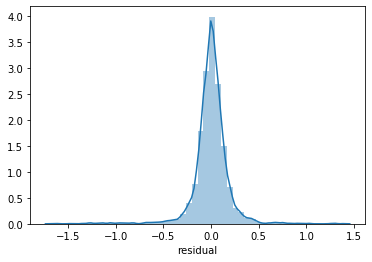

In [327]:
sns.distplot(res.resids)

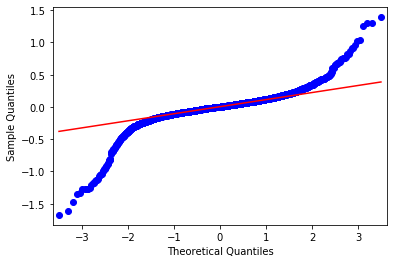

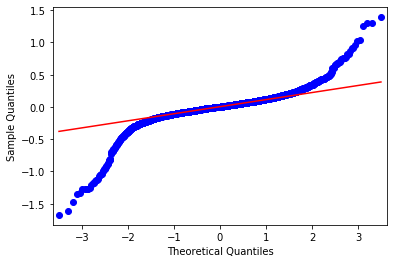

In [328]:
sm.graphics.qqplot(res.resids,line = 'q')

In [330]:
df.to_csv('temp.csv')

In [425]:
res.estimated_effects.index.unique()

MultiIndex([(    'Akron, OH Metro Area-Bus', 2002),
            (    'Akron, OH Metro Area-Bus', 2003),
            (    'Akron, OH Metro Area-Bus', 2004),
            (    'Akron, OH Metro Area-Bus', 2005),
            (    'Akron, OH Metro Area-Bus', 2006),
            (    'Akron, OH Metro Area-Bus', 2007),
            (    'Akron, OH Metro Area-Bus', 2008),
            (    'Akron, OH Metro Area-Bus', 2009),
            (    'Akron, OH Metro Area-Bus', 2010),
            (    'Akron, OH Metro Area-Bus', 2011),
            ...
            ('Yuba City, CA Metro Area-Bus', 2015),
            ('Yuba City, CA Metro Area-Bus', 2016),
            ('Yuba City, CA Metro Area-Bus', 2017),
            ('Yuba City, CA Metro Area-Bus', 2018),
            (     'Yuma, AZ Metro Area-Bus', 2013),
            (     'Yuma, AZ Metro Area-Bus', 2014),
            (     'Yuma, AZ Metro Area-Bus', 2015),
            (     'Yuma, AZ Metro Area-Bus', 2016),
            (     'Yuma, AZ Metro Area-Bus', 201

## Calculate FAC

In [426]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [427]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
ID                       Year                                         
Akron, OH Metro Area-Bus 2002          0            24    15.469231   
                         2003          0            24    15.501150   
                         2004          0            24    15.591676   
                         2005          0            24    15.609548   
                         2006          0            24    15.619001   

                               VRM_ADJ_log  FARE_per_UPT_2018_log  \
ID                       Year                                       
Akron, OH Metro Area-Bus 2002    15.208377               0.148254   
                         2003    15.195930               0.462904   
                         2004    15.277699               0.414204   
                         2005    15.214971               0.460804   
                         2006    15.200501               0.462420   

                               POP_EMP_log  GAS_PRICE_2018_log  \
ID                       Year                                    
Akron, OH Metro Area-Bus 2002    13.808216            1.066089   
                         2003    13.823451            1.138954   
                         2004    13.839439            1.233697   
                         2005    13.857195            1.361617   
                         2006    13.879496            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  PCT_HH_NO_VEH  \
ID                       Year                                                
Akron, OH Metro Area-Bus 2002                     10.479210           8.60   
                         2003                     10.446267           8.20   
                         2004                     10.403980           7.79   
                         2005                     10.365663           7.47   
                         2006                     10.305856           6.85   

                               TSD_POP_PCT  JTW_HOME_PCT  \
ID                       Year                              
Akron, OH Metro Area-Bus 2002    18.525984           3.1   
                         2003    18.076969           3.1   
                         2004    17.637662           3.1   
                         2005    17.243546           3.1   
                         2006    16.754287           2.5   

                               YEARS_SINCE_TNC_BUS2_HINY  \
ID                       Year                              
Akron, OH Metro Area-Bus 2002                        0.0   
                         2003                        0.0   
                         2004                        0.0   
                         2005                        0.0   
                         2006                        0.0   

                               YEARS_SINCE_TNC_BUS2_MIDLOW  \
ID                       Year                                
Akron, OH Metro Area-Bus 2002                          0.0   
                         2003                          0.0   
                         2004                          0.0   
                         2005                          0.0   
                         2006                          0.0   

                               YEARS_SINCE_TNC_RAIL2_HINY  \
ID                       Year                               
Akron, OH Metro Area-Bus 2002                         0.0   
                         2003                         0.0   
                         2004                         0.0   
                         2005                         0.0   
                         2006                         0.0   

                               YEARS_SINCE_TNC_RAIL2_MIDLOW  BIKE_SHARE  \
ID                       Year                                             
Akron, OH Metro Area-Bus 2002                           0.0         0.0   
                         2003                           0.0         0.0   
                         2004     

In [428]:
# calculate the fitted values
app_data['fitted'] = app_data['estimated_effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [429]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

# for tracking new systems
app_data['UPT_ADJ_first_year'] = 0
app_data['UPT_ADJ_new_reporter'] = 0


In [430]:
# get the ridership in the first year the system starts. This allows us to track new systems. 
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()
    first_year = years[0]

    app_data.loc[(id,first_year),'UPT_ADJ_new_reporter'] = app_data.loc[(id,first_year),'UPT_ADJ']
    
    for year in years: 
        app_data.loc[(id,year),'UPT_ADJ_first_year']   = app_data.loc[(id,first_year),'UPT_ADJ']


In [102]:
app_data.to_csv('temp.csv')

In [431]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'estimated_effects'] 
                                                    - app_data.loc[(id,base_year), 'estimated_effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])
        

/Users/rianajawad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/rianajawad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [432]:
# calculate the FAC
app_data['FAC_Sum'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['FAC_Sum'] = app_data['FAC_Sum'] + app_data[var+'_FAC']


In [433]:

# total FAC is based on the fitted model (applied multiplicitively)
app_data['Known_FAC'] = (app_data['fitted_exp_ratio'] - 1) * app_data['UPT_ADJ_base']

# uknown change is the difference between the observed change and the known change
app_data['Unknown_FAC'] = app_data['UPT_ADJ_diff'] - app_data['Known_FAC']

# the change in ridership associated new systems
app_data['New_Reporter_FAC'] = app_data['UPT_ADJ_new_reporter'] 

# should be teh same as UPT_ADJ_DIFF
app_data['Total_Change'] = app_data['Known_FAC'] + app_data['Unknown_FAC'] + app_data['New_Reporter_FAC']


In [434]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [435]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [436]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4',    
              'UPT_ADJ_first_year', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['FAC_Sum', 'Known_FAC', 'Unknown_FAC', 'New_Reporter_FAC', 'Total_Change']
    
# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [446]:
res.params.keys()

Index(['VRM_ADJ_log', 'FARE_per_UPT_2018_log', 'POP_EMP_log', 'TSD_POP_PCT',
       'GAS_PRICE_2018_log', 'TOTAL_MED_INC_INDIV_2018_log', 'PCT_HH_NO_VEH',
       'JTW_HOME_PCT', 'YEARS_SINCE_TNC_BUS2_HINY',
       'YEARS_SINCE_TNC_BUS2_MIDLOW', 'YEARS_SINCE_TNC_RAIL2_HINY',
       'YEARS_SINCE_TNC_RAIL2_MIDLOW', 'BIKE_SHARE', 'scooter_flag',
       'FAILURE_ALT_MODE_INTERACTION_log'],
      dtype='object')

In [437]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_first_year']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['CLUSTER_APTA4', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_first_year']
    

In [438]:

summary_data_apta4.to_csv('FAC_totals_APTA4_CLUSTERS.csv')


In [447]:
summary_data.head()

,ID,Year,RAIL_FLAG,CLUSTER_APTA,CLUSTER_APTA4,UPT_ADJ_first_year,UPT_ADJ_base,UPT_ADJ,UPT_ADJ_diff,fitted_exp,fitted_exp_diff,VRM_ADJ,FARE_per_UPT_2018,POP_EMP,GAS_PRICE_2018,TOTAL_MED_INC_INDIV_2018,PCT_HH_NO_VEH,TSD_POP_PCT,JTW_HOME_PCT,YEARS_SINCE_TNC_BUS2_HINY,YEARS_SINCE_TNC_BUS2_MIDLOW,YEARS_SINCE_TNC_RAIL2_HINY,YEARS_SINCE_TNC_RAIL2_MIDLOW,BIKE_SHARE,MDBF_Mechanical,scooter_flag,VRM_ADJ_log_FAC,FARE_per_UPT_2018_log_FAC,POP_EMP_log_FAC,GAS_PRICE_2018_log_FAC,TOTAL_MED_INC_INDIV_2018_log_FAC,PCT_HH_NO_VEH_FAC,TSD_POP_PCT_FAC,JTW_HOME_PCT_FAC,YEARS_SINCE_TNC_BUS2_HINY_FAC,YEARS_SINCE_TNC_BUS2_MIDLOW_FAC,YEARS_SINCE_TNC_RAIL2_HINY_FAC,YEARS_SINCE_TNC_RAIL2_MIDLOW_FAC,BIKE_SHARE_FAC,MDBF_Mechanical_log_FAC,scooter_flag_FAC,FAC_Sum,Known_FAC,Unknown_FAC,New_Reporter_FAC,Total_Change
0,"Akron, OH Metro Area-Bus",2002,0,24,2.0,5226385.66,0.000,5226385.660,0.000,6.668599e+06,0.000000e+00,2.104337e+13,8.352158e+05,5.188395e+12,9.951038e+06,1.858883e+11,4.494692e+07,9.682394e+07,1.620180e+07,0.0,0.0,0.0,0.0,0.0,2.768865e+11,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,5226385.66,5226385.660
1,"Akron, OH Metro Area-Bus",2003,0,24,2.0,5226385.66,5226385.660,5395901.888,169516.228,5.646749e+06,-1.021850e+06,2.078308e+13,3.076673e+06,5.268046e+12,1.109823e+07,1.798643e+11,4.285636e+07,9.447721e+07,1.620180e+07,0.0,0.0,0.0,0.0,0.0,1.093846e+12,0.0,-54009.678385,-880179.578951,32106.644897,66617.105695,48606.076587,-12444.217400,-13359.528017,0.000000,0.0,0.0,0.0,0.0,0.0,28144.994864,0.0,-784518.180710,-800855.108192,970371.336192,0.00,169516.228
2,"Akron, OH Metro Area-Bus",2004,0,24,2.0,5226385.66,5395901.888,5907162.281,511260.393,6.379511e+06,7.327621e+05,2.255391e+13,2.682000e+06,5.352950e+12,1.272050e+07,1.724166e+11,4.071354e+07,9.218123e+07,1.620180e+07,0.0,0.0,0.0,0.0,0.0,3.366255e+11,0.0,381093.664586,156236.035073,34791.674760,89598.648233,64502.251794,-13168.645595,-13494.967549,0.000000,0.0,0.0,0.0,0.0,0.0,-24801.775814,0.0,674756.885487,700210.384288,-188949.991288,0.00,511260.393
3,"Akron, OH Metro Area-Bus",2005,0,24,2.0,5226385.66,5907162.281,6013680.881,106518.600,6.083326e+06,-2.961850e+05,2.118260e+13,3.059251e+06,5.448846e+12,1.516958e+07,1.659350e+11,3.904110e+07,9.012142e+07,1.620180e+07,0.0,0.0,0.0,0.0,0.0,1.253408e+11,0.0,-301299.859181,-159154.517688,42314.373959,132821.659784,63947.201671,-11254.819085,-13255.615607,0.000000,0.0,0.0,0.0,0.0,0.0,-22769.625654,0.0,-268651.201802,-274254.973295,380773.573295,0.00,106518.600
4,"Akron, OH Metro Area-Bus",2006,0,24,2.0,5226385.66,6013680.881,6070797.419,57116.538,6.201663e+06,1.183369e+05,2.087829e+13,3.072651e+06,5.571726e+12,1.659377e+07,1.563016e+11,3.580074e+07,8.756436e+07,1.306596e+07,0.0,0.0,0.0,0.0,0.0,1.257728e+11,0.0,-72188.291875,-5693.054073,54153.322916,70971.932727,101921.045902,-22179.596860,-16747.795200,7560.912878,0.0,0.0,0.0,0.0,0.0,80.889356,0.0,117879.365770,116982.106964,-59865.568964,0.00,57116.538


In [84]:
df.to_csv('temp.csv')